In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import datasets
from sklearn import metrics

from scipy.cluster.hierarchy import dendrogram, linkage 
from bioinfokit.visuz import cluster
from bioinfokit.analys import get_data

# Load data
df = pd.read_csv('UsArrests.csv',index_col=0)

temp_df = df.copy()

# Enable seeing entire dataset in output.
pd.set_option("display.max_rows", None, "display.max_columns", None)

# PRE PROCESSING

In [13]:
# Check for any NaN values.
missing_values_count = temp_df.isnull().sum()
missing_values_count[::]

# There are no missing values. 

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [3]:
# Get initial idea of general stats. 
temp_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


### COMMENT/ANALYSIS
From the stats, we can see that Assault has by far the highest mean of arrests/100 000 residents (170.76) with Rape far behind with 21,23 arrests/100 000. Furthermore, Assault has the highest Min value(45/100 000) and the highest max value (337/100 000). 

Max value for Assault is 337.0, which is a much bigger value than the rest of the values. Scaling is required.

### STANDARDIZE DATA

In [4]:
temp_df = df.copy()
temp_df_st =  StandardScaler().fit_transform(temp_df) 
X = StandardScaler().fit_transform(temp_df.values) 

# Check that standardization has been successfully done. 
pd.DataFrame(temp_df_st, columns=temp_df.columns).head(5)

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


# PCA

##### (1) PRE-PCA HEATMAP

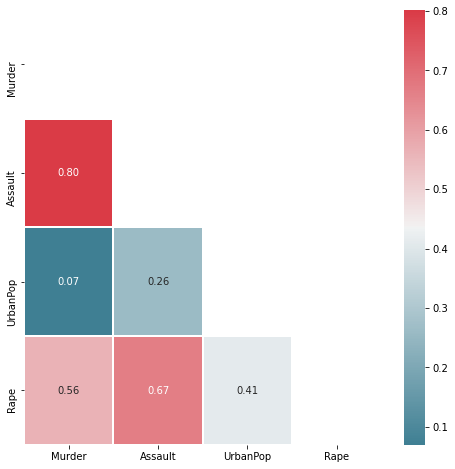

In [5]:
# Create a plot of the data using all features to show the positive and negative correlations between them.
colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(temp_df_st):
  # get correlations
  corrs = temp_df.corr()

  # pick appropriate palette for heatmap

  # Plot figsize
  fig, ax = plt.subplots(figsize=(8, 8))

  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.show()

corr_heatmap(temp_df_st)

##### (2) BIPLOT & HEATMAP

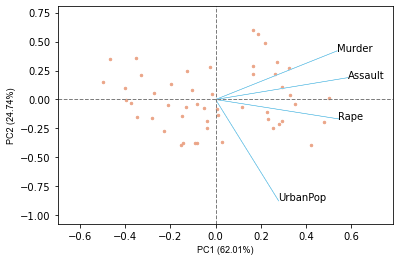

In [6]:
# Perform PCA-get PC scores
pca_out = PCA().fit(temp_df_st)
loadings = pca_out.components_
pca_scores = PCA().fit_transform(temp_df_st)

# get 2D biplot
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=temp_df.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2),show=True)


##### (3) SCREE PLOT

Text(0, 0.5, 'cumulative explained variance')

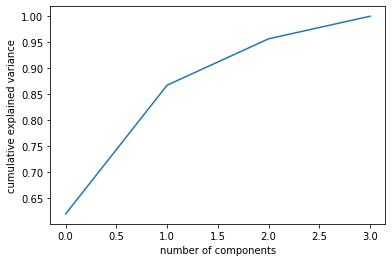

In [7]:
plt.plot(np.cumsum(pca_out.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

##### (4) EIGENVALUES AND CUMULATIVE EXPLAINED VARIANCE/NO. OF COMPONENTS

In [8]:
# Get eigenvalues (variance explained by each PC)  
explained_variance = pca_out.explained_variance_
print("Eigenvalues-Explained variance: ",explained_variance)

Eigenvalues-Explained variance:  [2.53085875 1.00996444 0.36383998 0.17696948]


##### (5) Primary Component Analysis

Porportion of variance:  [0.62006039 0.24744129 0.0891408  0.04335752]

Cumulative variance:  [0.62006039 0.86750168 0.95664248 1.        ]


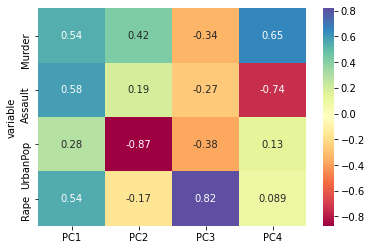

In [12]:
# Get the component variance.
# Proportion of Variance (from Primary Component 1 - Primary Component 4).
prop_var = pca_out.explained_variance_ratio_
print("Porportion of variance: ",prop_var)

# Cumulative proportion of variance (from Primary Component 1 - Primary Component 4).  
cum_var = np.cumsum(pca_out.explained_variance_ratio_)
print("\nCumulative variance: ",cum_var)

# Create heatmap matrix with correlations of Primary Components and the columns. 
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = temp_df.columns.values
loadings_df = loadings_df.set_index('variable')

ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

## COMMENT/ANALYSIS

##### (1) HEATMAP
Pre-PCA Implementation.

There is only 1 strong positive correlation, between Murder and Assault (0.8). The next highest positive correlation is between Assault and Rape (0.67), followed by Murder/Rape (0.56). The rest of the variables do not correlate strongly wth one another.

The strong positive correlation between Murder and Assault could be because murder can be thought of as a specific kind of assault-an assault that leads to death. Similar logic can be applied to Assault/Rape. 

Regarding Assault/Rape, it could be that there is an under-reporting of rapes and the correlation between Assault/Rape could be stronger/higher value, closer to the positive correlation value between Assault/Murder. This could be because those cases reported as assaults-particularly cases reported by women-may actually be cases of rape, as women who have experienced the trauma of being raped may be reluctant to tell the authorities that they were raped. Instead, they report the incident as just a case of assault.   

##### (2) BIPLOT & HEATMAP
A loading plot shows how strongly each characteristic influences a principal component.

Post-PCA Implementation, what stands out is the strong negative correlation between UrbanPop (percent of the population living in urban areas) and PC2, i.e. there higher percentage of people that live in urban areas, the less arrests. Also, there is a slight positive correlation between Assault and PC1, and similarly with Murder and Rape and PC1. On the other hand, there are weak correlations between UrbanPop and PC1, Asssault and PC2, and Rape and PC2. 

In summary, Rape, Assault, Murder have moderate influence over PC1, while UrbanPop has a big influence over PC2. This last point, particularly that UrbanPop is strongly negatively correlated with PC2, hints that the higher the percentage of people living in urban areas, the lower the crime rate. Whether this could be attributed to more concentrated law enforcement in urban areas, the corollary that urban-dwellers are thus disuaded from commiting these crimes as they risk more likely being caught, needs further investigation. 

##### (3) SCREE PLOT 
A scree plot displays how much variation each principal component captures from the data.

The Scree plot shows that 2 components account for around 95% of the variance. So we can visualise the clusters by reducing the dimensions into 2 using PCA.

##### (4) EIGENVALUES 
A good rule of thumb is that PCs with eigenvalues > 1 contributes greater variance and should be retained for further analysis.We see that PC1 and PC2 fit this criterion (at 2.53085875 1.00996444 respectively) and they should be retained.


##### (5) Primary Component Analysis
The cumulative variance shows that 95% of the variance is due to PC1, PC2, and PC3, with each accounting for around 62%, 25%, and 9% respectively. 

From the heatmap, we see strong positive correlation between PC3 and Rape, as well as strong negative correlation between PC2 and UrbanPop, and PC4 and Assault. 


# CLUSTERING I-HIERARCHICAL CLUSTERING

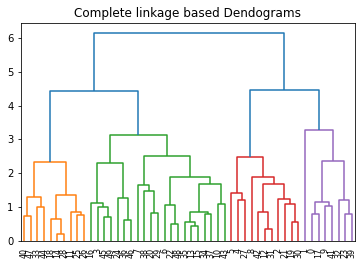

In [9]:
plt.title("Complete linkage based Dendograms")  
dend = dendrogram(linkage(X, method='complete'))  

Silhouette Score:  0.369


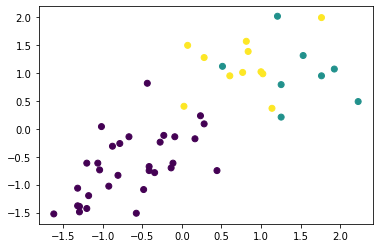

In [14]:
K = 3
L = 'complete'

cluster = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=L)
cluster.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=cluster.labels_)

# GET SILHOUETTE SCORE
score = round(silhouette_score(X, cluster.labels_),3)
print("Silhouette Score: ",score)


### COMMENT/ANALYSIS

Using complete linkage, the dendrogram shows that the clusters sizes are 10 (yellow), 21 (green), 11 (red), and 8 (purple). The complete linkage is appropriate as there is a good balance between the different coloured clusters. The shortest distance line-i.e. the most similar points-is between the numbers 24 and 28 in the yellow cluster, followed by 31 and 2 in the red cluster. Looking at the green and purple clusters, it appears that the threshold is 3, so we will set K = 3. 

With K = 3 and linkage = complete, we see that the purple cluster is virtually disctinct and separate from the other clusters. However, the yellow and blue clusters are not as separated from one another, clearly demonstrated by the overlap between them at specific places. The Silhouette Score (0.369) confirms that the clusters are somewhat distinct but overlapping is still evident. 


# CLUSTERING II-K-MEANS

Silhouette Score:  0.31


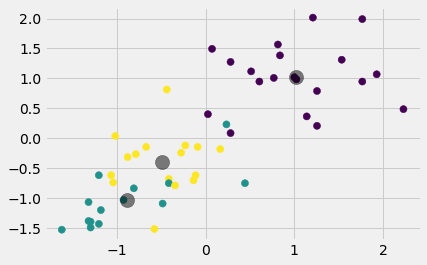

In [60]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# Get accuracy of the model. 
score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
print("Silhouette Score: ",score)


### COMMENT/ANALYSIS

The K-means algorithm yielded worse results than the hierarchical/agglomerative clustering used above (Silhouette Score:  0.31 vs 0.369). While the topmost purple cluster is mostly distinct and separate from the other clusters, the blue and yellow clusters exhibit considerable overlap. The worse results could possibly be attributed to the limitations of k-means clustering (too much noise in the data, inability to deal with outliers, etc.) in addition to the data not being suitable for clustering.  